## Langgraph

# Lecture 10- Langgraph Day 3

### Step 1: Setup LLM code

In [11]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from .env file

# Corrected way to retrieve the API key
api_key = os.getenv("GOOGLE_API_KEY")

if not api_key:
    raise ValueError("GOOGLE_API_KEY not found. Make sure it's set in the .env file.")

os.environ["GOOGLE_API_KEY"] = api_key

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

### Step 2:
Start by creating a StateGraph. A StateGraph object defines the structure of our Chatbot as "state machine". We'll add nodes to represent the LLM and functions our Chatbot can call and edges to specify how the bot should transition between these functions. When defining a graph, the first step is to define it's State. The State includes the graph's schema and reducer functions that handle state updates.
In our example, State is a TypedDict with one key: messages. The add_messages reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer function will be overwritten previous values.

In [12]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import START, StateGraph, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """The state of the chatbot."""
    # Messages have the type "list". The 'add_messages' function will add messages to this list.
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)

    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Step 3:
Defines nodes, Nodes represent units of work. They are typically regular python functions.

In [7]:
%pip install tavily-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [29]:
# Step 1: Define a tool

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from tavily import TavilyClient

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000000))
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

# print(wikipedia.run({"query": "What is the capital of France?"}))
def wikipedia_tool(query: str) -> str:
    """Goes to wikipedia and searches for the query
    Args:
        query (str): The query to search for.
    Returns:
        str: The result to the query.
    """
    wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000000))
    return wikipedia.run({"query": query})


def tavily_tool(query: str) -> str:
    """Goes to tavily search and searches for the query and gives the detailed content
    Args:
        query (str): The query to search for.
    Returns:
        str: The result to the query.
    """

    respone = tavily_client.search(query)
    content = ""
    for result in respone['results']:
        content += result['content']
    return content

llm_with_wikipedia_tool = llm.bind_tools([wikipedia_tool])
llm_with_tavily_tool = llm.bind_tools([tavily_tool])

from langchain_core.messages import SystemMessage

sys_message_wikipedia = SystemMessage(content="You are a helpful assistant that breaks down the query into a key word and searches wikipedia for the key word")
sys_message_tavily = SystemMessage(content="You are a helpful assistant that breaks down the query into a key word and searches tavily for the key word")

# Define Nodes
def wikipedia_llm(state: State):
    return {"messages": [llm_with_wikipedia_tool.invoke([sys_message_wikipedia] + state["messages"])]}
sys_message_summarize = SystemMessage(content="You are a helpful assistant that summarizes the content given to you")

def summarize_llm(state: State):
    """Summarizes the wikipedia content"""
    return {"messages": [llm.invoke([sys_message_summarize] + state["messages"])]}


# def tavily_llm(state: State):
#     return {'messages': [llm_with_tavily_tool.invoke([sys_message_tavily] + state["messages"] )]}

## Define Graph

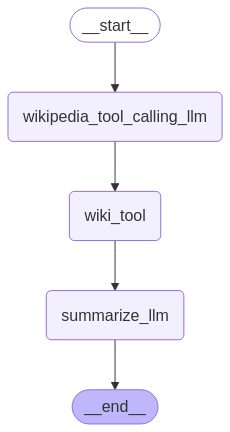

In [31]:
from IPython.display import display, Image
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(State)
graph_builder.add_node("wikipedia_tool_calling_llm", wikipedia_llm)
graph_builder.add_node("wiki_tool", ToolNode([wikipedia_tool]))
graph_builder.add_node("summarize_llm", summarize_llm)
# graph_builder.add_node("tavily_tool_calling_llm", tavily_llm)  
# graph_builder.add_node("tavily_tool",ToolNode([tavily_tool]))

graph_builder.add_edge(START, "wikipedia_tool_calling_llm")
# graph_builder.add_edge(START, "tavily_tool_calling_llm")
# graph_builder.add_edge("tavily_tool_calling_llm", "tavily_tool")
graph_builder.add_edge("wikipedia_tool_calling_llm", "wiki_tool")

graph_builder.add_edge("wiki_tool", "summarize_llm")
# graph_builder.add_edge("tavily_tool", "summarize_llm")
graph_builder.add_edge("summarize_llm", END)

graph = graph_builder.compile()

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependiencies
    pass

## Check the Graph

In [35]:
from langchain_core.messages import HumanMessage
messages = graph.invoke({"messages": [HumanMessage(content="Pakistani Food")]})

In [36]:
messages

{'messages': [HumanMessage(content='Pakistani Food', additional_kwargs={}, response_metadata={}, id='a987cbd2-2e7c-4059-b6fe-d2c81deee581'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia_tool', 'arguments': '{"query": "Pakistani Food"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fc6361fe-b16e-429a-9639-92600c45a437-0', tool_calls=[{'name': 'wikipedia_tool', 'args': {'query': 'Pakistani Food'}, 'id': '012597ad-766b-44ca-b797-014a34177ce0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 65, 'output_tokens': 7, 'total_tokens': 72, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="Page: Pakistani cuisine\nSummary: Pakistani cuisine (Urdu: پاکستانی پکوان, romanized: pākistānī pakwān) is a blend of regional cooking styles and flavours from across South, Central and West Asia. The cuisine of Pakistan also maintains certain Mughal influence

In [37]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Pakistani Food
================================== Ai Message ==================================
Tool Calls:
  wikipedia_tool (012597ad-766b-44ca-b797-014a34177ce0)
 Call ID: 012597ad-766b-44ca-b797-014a34177ce0
  Args:
    query: Pakistani Food
================================= Tool Message =================================
Name: wikipedia_tool

Page: Pakistani cuisine
Summary: Pakistani cuisine (Urdu: پاکستانی پکوان, romanized: pākistānī pakwān) is a blend of regional cooking styles and flavours from across South, Central and West Asia. The cuisine of Pakistan also maintains certain Mughal influences within its recipes and cooking techniques, particularly the use of dried fruits and nuts. Pakistan's ethnic and cultural diversity, diverse climates, geographical environments, and availability of different produce lead to diverse regional cuisines.
Pakistani cuisine, like the culinary traditions of most Mus